In [1]:
# We want to conduct sentiment analysis on the comment data
# We would be interested in the overall sentiment regarding different dominant topics...
# Import the required packages
import pandas as pd 
import numpy as np 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

In [2]:
# load in the data and preprocess it ~ we generally expect that the stopwords are similar to what we have 
# encountered in the past, we will also be using vader lexicon ~ suitable for social media
# perhaps account for abbreviations
txt_df = pd.read_csv(r'C:\Users\huang\OneDrive\Documents\ECO481\text_df.csv')
# Create re function to remove punctuations
regex = re.compile('[%s]' % re.escape("[-,\.!?:’â€¦™]"))
def test_re(s):  # From Vinko's solution, with fix.
    return regex.sub("", s)
# perhaps we also need to drop duplicated columns, this is dependent on subset of id and comment
txt_df.drop_duplicates(subset = ['User ID', 'Comments'], inplace = True)
txt_df.reset_index(inplace = True)
txt_df.head()

,index,Unnamed: 0,User ID,Comments,Upvotes
0,0,0,jbe3ase,This seems to address a lot of the feedback so...,250
1,1,1,jbe3kcn,Cruor's Vow would work with all combat styles ...,97
2,2,2,jbe8g6l,"During the initial proposal I was like: hmm, f...",6
3,3,3,jbfo38h,"Given the power of the book, I don’t think we ...",1
4,4,4,jbe3exk,"For Glacies' Vow, is the bonus magic damage de...",72


In [3]:
# preprocess and then create bigram models:
# this is a bit challenging ~ some of these words are outright filler like names and such
# these refer to a neutral object so to speak, like you could say bad/good things about any of these objects.
# comments to words
def comments_to_words(comments):
    l1 = []
    for comment in comments:
        l1.append(gensim.utils.simple_preprocess(str(comment), deacc=True))
    return l1
txt_words = comments_to_words(txt_df['Comments'])
# Set up bigrams
bigram = Phrases(txt_words, min_count=1, threshold=2, delimiter=' ')

bigram_phraser = Phraser(bigram)
print(bigram_phraser)
ps = PorterStemmer()
stop = set(stopwords.words('english'))
# Now get me some punctuations 
punctuations = set(string.punctuation)
lemmatizer = WordNetLemmatizer()
# Add in the abbreviations
stop.add('tbh')
stop.add('imo')

FrozenPhrases<5331 phrases, min_count=1, threshold=2>


In [4]:
# Now we process the texts:
# Should I pre-process the text? Probably. Remove punctuations and stopwords...
# perhaps put headlines into lower-case as well...
ps = PorterStemmer()
stop = set(stopwords.words('english'))
# Now get me some punctuations 
punctuations = set(string.punctuation)
lemmatizer = WordNetLemmatizer()
# Apply some early pre-processing
comment_list = []
for item in txt_df['Comments']:
    comment_list.append(test_re(item).lower())
txt_df['Comments Simplified'] = comment_list
# Attach tags to words ~ hopefully lets us lemmatize more easily
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
# How will it handle names?

In [5]:
# preprocess function
def preprocess(text):
    # STOPWORD REMOVAL
    doc1 = text.lower()
    doc2 = doc1.split()
    doc3 = [val for val in doc2 if val not in stop]
    doc4 = " ".join(doc3)
    # print(doc4)
    # PUNCTUATION REMOVAL
    # would this be like 'contains', that is if it contains punctuations, then removed?
    doc5 = [val for val in doc4 if val not in punctuations]
    # print(doc5)
    doc6 = "".join(doc5)
    # print(doc6)
    # lemmatize instead, more useful than stem
    # but we need to determine if noun, verb or whatever 
    words = word_tokenize(doc6)
    # print(words)
    # associate with right tags
    tags = [get_wordnet_pos(word) for word in words]
    ind = 0 
    lem_final = []
    while ind in range(len(words)):
        lem = lemmatizer.lemmatize(words[ind], tags[ind])
        lem_final.append(lem)
        ind += 1 
    final = " ".join(lem_final)
    return final
# Make bi-grams and also the processed comments
processed_list = []
bigram_list = []
for item in txt_df['Comments Simplified']:
    processed_list.append(preprocess(item))
    bigram_list.append(bigram_phraser[preprocess(item).split()])
txt_df['Processed Comments'] = processed_list
txt_df['Bi-grams'] = bigram_list
txt_df.head()

,index,Unnamed: 0,User ID,Comments,Upvotes,Comments Simplified,Processed Comments,Bi-grams
0,0,0,jbe3ase,This seems to address a lot of the feedback so...,250,this seems to address a lot of the feedback so...,seem address lot feedback far really nice chan...,"[seem, address, lot, feedback, far, really, ni..."
1,1,1,jbe3kcn,Cruor's Vow would work with all combat styles ...,97,cruor's vow would work with all combat styles ...,cruors vow would work combat style yeah ill up...,"[cruors vow, would work, combat style, yeah, i..."
2,2,2,jbe8g6l,"During the initial proposal I was like: hmm, f...",6,during the initial proposal i was like hmm fin...,initial proposal like hmm fine whatever iterat...,"[initial proposal, like, hmm, fine, whatever, ..."
3,3,3,jbfo38h,"Given the power of the book, I don’t think we ...",1,given the power of the book i dont think we ca...,give power book dont think conclude itll feel ...,"[give, power, book, dont think, conclude, itll..."
4,4,4,jbe3exk,"For Glacies' Vow, is the bonus magic damage de...",72,for glacies' vow is the bonus magic damage dea...,glacies vow bonus magic damage dealt secondary...,"[glacies vow, bonus magic, damage dealt, secon..."


In [6]:
# We now aim to find the optimal # of topics 
import gensim
from gensim.models import CoherenceModel
# Create dictionary for id and words
# print(nyt_df['Processed Headlines'].type())
# add in column that is processed split words
split_words = []
for item in txt_df['Processed Comments']:
    split_words.append(item.split())
txt_df['Processed Comments List'] = split_words
# We used a bag of words model ~ look to incorporate TF_IDF in the future 
# id2word ~ associate ID to words in the headlines, corpus should be the headlines ~ the id of words and how many 
# times they appear?
id2word1 = gensim.corpora.Dictionary(txt_df['Bi-grams'])
corpus1 = [id2word1.doc2bow(text) for text in txt_df['Bi-grams']]
# Calculate optimal number of topics
number_of_topics = []
coherence_score = []
lda_list = []
for i in range(1, 15, 1):
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus1, id2word = id2word1, iterations = 1000, random_state = i,
                                                num_topics = i)
    lda_list.append(lda_model)
    coherence_model_lda = CoherenceModel(model = lda_model, texts = txt_df['Bi-grams'], dictionary = id2word1,
                                        coherence = 'c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_score.append(coherence_lda)
# store in a df 
topic_coherence = pd.DataFrame(list(zip(number_of_topics, coherence_score)), columns = ['Number of Topics', 'Coherence Score'])
topic_coherence

,Number of Topics,Coherence Score
0,1,0.311344
1,2,0.327839
2,3,0.377772
3,4,0.391026
4,5,0.370221
5,6,0.359285
6,7,0.391044
7,8,0.388873
8,9,0.380548
9,10,0.363165


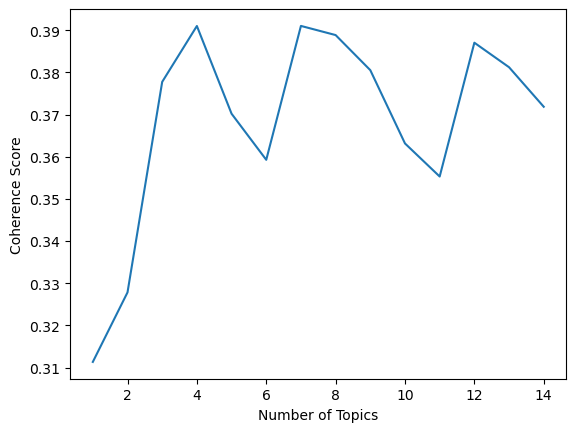

In [7]:
# graph coherence score:
x_ax = topic_coherence['Number of Topics']
y_ax = topic_coherence['Coherence Score']
plt.figure()
plt.plot(x_ax, y_ax)
xl=plt.xlabel('Number of Topics')
yp=plt.ylabel('Coherence Score')
# significant trough at k = 5

In [8]:
# we are using 4 topics
all_topic_dists = [lda_list[3].get_document_topics(d) for d in corpus1]
txt_df['Dominant Topic'] = [max(d, key = lambda i: i[1])[0] for d in all_topic_dists]
txt_df.head()

,index,Unnamed: 0,User ID,Comments,Upvotes,Comments Simplified,Processed Comments,Bi-grams,Processed Comments List,Dominant Topic
0,0,0,jbe3ase,This seems to address a lot of the feedback so...,250,this seems to address a lot of the feedback so...,seem address lot feedback far really nice chan...,"[seem, address, lot, feedback, far, really, ni...","[seem, address, lot, feedback, far, really, ni...",3
1,1,1,jbe3kcn,Cruor's Vow would work with all combat styles ...,97,cruor's vow would work with all combat styles ...,cruors vow would work combat style yeah ill up...,"[cruors vow, would work, combat style, yeah, i...","[cruors, vow, would, work, combat, style, yeah...",2
2,2,2,jbe8g6l,"During the initial proposal I was like: hmm, f...",6,during the initial proposal i was like hmm fin...,initial proposal like hmm fine whatever iterat...,"[initial proposal, like, hmm, fine, whatever, ...","[initial, proposal, like, hmm, fine, whatever,...",0
3,3,3,jbfo38h,"Given the power of the book, I don’t think we ...",1,given the power of the book i dont think we ca...,give power book dont think conclude itll feel ...,"[give, power, book, dont think, conclude, itll...","[give, power, book, dont, think, conclude, itl...",3
4,4,4,jbe3exk,"For Glacies' Vow, is the bonus magic damage de...",72,for glacies' vow is the bonus magic damage dea...,glacies vow bonus magic damage dealt secondary...,"[glacies vow, bonus magic, damage dealt, secon...","[glacies, vow, bonus, magic, damage, dealt, se...",0


In [9]:
# sentiment scores
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    neg_score = sentiment_dict['neg']
    neu_score = sentiment_dict['neu']
    pos_score = sentiment_dict['pos']
    compound_score = sentiment_dict['compound']
    l = [neg_score, neu_score, pos_score, compound_score]
    return l
neg_l = []
neu_l = []
pos_l = []
com_l = []
for item in txt_df['Processed Comments']:
    scores_l = sentiment_scores(item)
    neg_l.append(scores_l[0])
    neu_l.append(scores_l[1])
    pos_l.append(scores_l[2])
    com_l.append(scores_l[3])
txt_df['Negative Score'] = neg_l
txt_df['Neutral Score'] = neu_l
txt_df['Positive Score'] = pos_l
txt_df['Compound Score'] = com_l
txt_df.head()

,index,Unnamed: 0,User ID,Comments,Upvotes,Comments Simplified,Processed Comments,Bi-grams,Processed Comments List,Dominant Topic,Negative Score,Neutral Score,Positive Score,Compound Score
0,0,0,jbe3ase,This seems to address a lot of the feedback so...,250,this seems to address a lot of the feedback so...,seem address lot feedback far really nice chan...,"[seem, address, lot, feedback, far, really, ni...","[seem, address, lot, feedback, far, really, ni...",3,0.156,0.639,0.205,0.5509
1,1,1,jbe3kcn,Cruor's Vow would work with all combat styles ...,97,cruor's vow would work with all combat styles ...,cruors vow would work combat style yeah ill up...,"[cruors vow, would work, combat style, yeah, i...","[cruors, vow, would, work, combat, style, yeah...",2,0.317,0.549,0.134,-0.4588
2,2,2,jbe8g6l,"During the initial proposal I was like: hmm, f...",6,during the initial proposal i was like hmm fin...,initial proposal like hmm fine whatever iterat...,"[initial proposal, like, hmm, fine, whatever, ...","[initial, proposal, like, hmm, fine, whatever,...",0,0.000,0.677,0.323,0.5106
3,3,3,jbfo38h,"Given the power of the book, I don’t think we ...",1,given the power of the book i dont think we ca...,give power book dont think conclude itll feel ...,"[give, power, book, dont think, conclude, itll...","[give, power, book, dont, think, conclude, itl...",3,0.100,0.831,0.070,-0.2263
4,4,4,jbe3exk,"For Glacies' Vow, is the bonus magic damage de...",72,for glacies' vow is the bonus magic damage dea...,glacies vow bonus magic damage dealt secondary...,"[glacies vow, bonus magic, damage dealt, secon...","[glacies, vow, bonus, magic, damage, dealt, se...",0,0.377,0.449,0.174,-0.9274


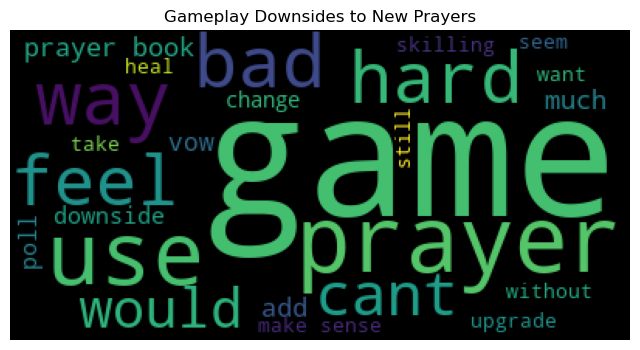

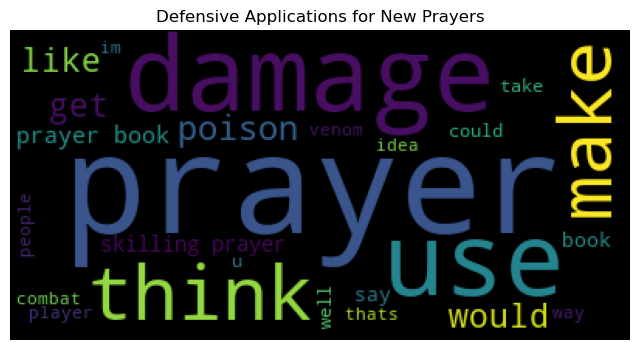

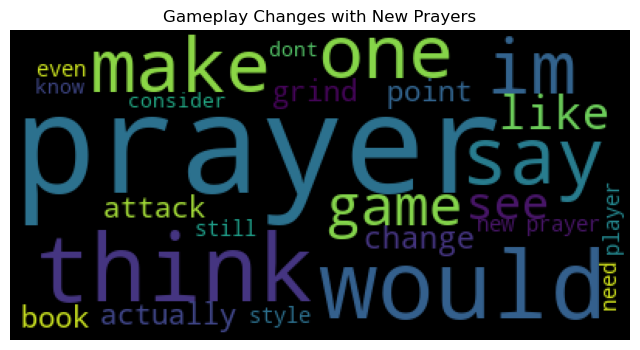

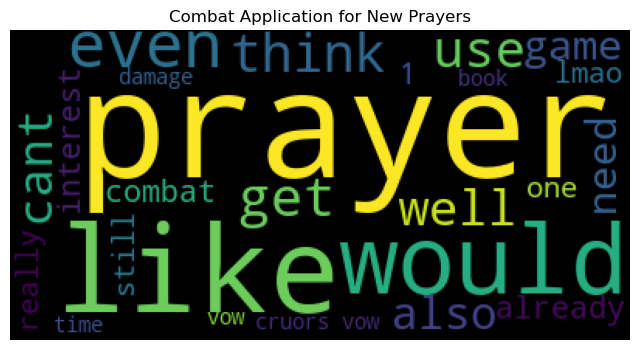

In [15]:
# wordcloud
topic_list = ['Gameplay Downsides to New Prayers', 'Defensive Applications for New Prayers', 'Gameplay Changes with New Prayers',
             'Combat Application for New Prayers']
topic_ind = 0
for t in range(lda_list[3].num_topics):
    #plt.figure()
    plt.figure(figsize = (8, 8))
    plt.imshow(WordCloud().fit_words(dict(lda_list[13].show_topic(t, 25))))
    plt.axis("off")
    plt.title(topic_list[topic_ind])
    plt.show()
    topic_ind += 1

In [17]:
# group by topics, and take the average of the compound scores
aggregate_sentiment_df = txt_df[['Dominant Topic', 'Negative Score', 'Neutral Score', 'Positive Score', 'Compound Score']].groupby(by = ['Dominant Topic']).mean()
aggregate_sentiment_df.index = topic_list
aggregate_sentiment_df

,Negative Score,Neutral Score,Positive Score,Compound Score
Gameplay Downsides to New Prayers,0.125570,0.640641,0.215581,0.221394
Defensive Applications for New Prayers,0.134134,0.697675,0.168188,0.061254
Gameplay Changes with New Prayers,0.154706,0.646766,0.198525,0.105041
Combat Application for New Prayers,0.162159,0.642311,0.195533,0.049417


In [ ]:
# perhaps look at the wordclouds?